# Experiment: XGB Boost AZ encoding

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
DATA_DIR = Path("data/").resolve()

EXPERIMENT_NAME = "02_xgboost-az-encoding"

EXPERIMENT_DIR = Path(f"experiments/{EXPERIMENT_NAME}").resolve()

os.makedirs(EXPERIMENT_DIR, exist_ok=True)

In [3]:
training_set = pd.read_csv(DATA_DIR / "training_set.csv", delimiter=",")

training_set_back = training_set.copy()

# Fix outliers. Looks like an error in data entry

training_set.loc[training_set.D3D > 10000, "D3D"] = training_set.D3D / 1000
training_set.loc[training_set.D2D > 10000, "D2D"] = training_set.D2D / 1000
training_set.loc[training_set.AZ > 1000, "AZ"] = training_set.AZ / 1000

### Preprocessing

In [4]:
id_features = ["ID_FILA", "ID_EVENTO"]

In [5]:
categorical_features = [
    "CAMPO",
    "FLUIDO",
    "HIJO",
    "PAD_HIJO",
    "PADRE",
    "LINEAMIENTO",
    "ESTADO"
]

In [6]:
training_set = training_set.drop(labels=id_features, axis=1)

In [7]:
training_set["AZ_sin"] = training_set["AZ"].transform(lambda x: np.sin(x * (np.pi / 180)))
training_set["AZ_cos"] = training_set["AZ"].transform(lambda x: np.cos(x * (np.pi / 180)))

training_set = training_set.drop(labels=["AZ"], axis=1)

### Target Encoding + Additive smoothing

In [8]:
smooth_means = {}

In [9]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Store the smoothed mean for each value of `by`
    smooth_means[smooth.index.name] = smooth.to_dict()

In [10]:
for c in categorical_features:
    calc_smooth_mean(training_set, by=c, on='delta_WHP', m=1000)

In [11]:
for c in categorical_features:
    training_set[c] = training_set[c].map(smooth_means[c])

### XGB Regressor

In [12]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26178 entries, 0 to 26177
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CAMPO        26178 non-null  float64
 1   FLUIDO       26178 non-null  float64
 2   PAD_HIJO     26178 non-null  float64
 3   HIJO         26178 non-null  float64
 4   ETAPA_HIJO   26178 non-null  int64  
 5   PADRE        26178 non-null  float64
 6   D3D          26178 non-null  float64
 7   D2D          26178 non-null  float64
 8   DZ           26178 non-null  float64
 9   #_BARRERAS   26178 non-null  float64
 10  LINEAMIENTO  26178 non-null  float64
 11  WHP_i        26178 non-null  float64
 12  delta_WHP    26178 non-null  float64
 13  ESTADO       26178 non-null  float64
 14  AZ_sin       26178 non-null  float64
 15  AZ_cos       26178 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 3.2 MB


In [13]:
df_train = training_set.sample(frac=0.75)
df_test = training_set[~training_set.index.isin(df_train.index)]

len(df_train), len(df_test)

(19634, 6544)

In [14]:
TARGET = "delta_WHP"

X_train = df_train.drop(TARGET, axis=1)
y_train = df_train[TARGET]

X_test = df_test.drop(TARGET, axis=1)
y_test = df_test[TARGET]

In [15]:
reg = xgb.XGBRegressor(
    n_estimators=1000,
    objective="reg:squarederror",
    early_stopping_rounds=50,
    learning_rate=0.1,
)

In [16]:
reg.fit(
    X=X_train,
    y=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

[0]	validation_0-rmse:7.26798	validation_1-rmse:7.27029
[1]	validation_0-rmse:6.93140	validation_1-rmse:7.03766
[2]	validation_0-rmse:6.63584	validation_1-rmse:6.84822
[3]	validation_0-rmse:6.37829	validation_1-rmse:6.71999
[4]	validation_0-rmse:6.15787	validation_1-rmse:6.58434
[5]	validation_0-rmse:5.95581	validation_1-rmse:6.47951
[6]	validation_0-rmse:5.77474	validation_1-rmse:6.38123
[7]	validation_0-rmse:5.61064	validation_1-rmse:6.32939
[8]	validation_0-rmse:5.46264	validation_1-rmse:6.24014
[9]	validation_0-rmse:5.34196	validation_1-rmse:6.19596
[10]	validation_0-rmse:5.20600	validation_1-rmse:6.16552
[11]	validation_0-rmse:5.10048	validation_1-rmse:6.12443
[12]	validation_0-rmse:5.00678	validation_1-rmse:6.08549
[13]	validation_0-rmse:4.90873	validation_1-rmse:6.08251
[14]	validation_0-rmse:4.81941	validation_1-rmse:6.05719
[15]	validation_0-rmse:4.74741	validation_1-rmse:6.03017
[16]	validation_0-rmse:4.67362	validation_1-rmse:6.02688
[17]	validation_0-rmse:4.60784	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [17]:
reg.save_model(EXPERIMENT_DIR / "xgb-model")

In [18]:
fi = pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["importance"]
)

fi = fi.sort_values("importance", ascending=False)

fi

,importance
D3D,0.142546
HIJO,0.142153
FLUIDO,0.109519
ETAPA_HIJO,0.083337
PADRE,0.083271
PAD_HIJO,0.074144
AZ_cos,0.067341
DZ,0.059742
WHP_i,0.055609
D2D,0.042527


## Predictions

### Pre-process preds set

In [19]:
predictions_set = pd.read_csv(DATA_DIR / "predictions_set.csv", delimiter=",")

predictions_set["D3D"] = predictions_set["D3D"].transform(lambda d: d.replace(",", "."))
predictions_set["D3D"] = predictions_set["D3D"].astype(float)

predictions_set["WHP_i"] = predictions_set["WHP_i"].transform(lambda d: d.replace(",", "."))
predictions_set["WHP_i"] = predictions_set["WHP_i"].astype(float)

predictions_set_back = predictions_set.copy()

predictions_set["AZ_sin"] = predictions_set["AZ"].transform(lambda x: np.sin(x * (np.pi / 180)))
predictions_set["AZ_cos"] = predictions_set["AZ"].transform(lambda x: np.cos(x * (np.pi / 180)))

predictions_set = predictions_set.drop(labels=["AZ"], axis=1)

predictions_set = predictions_set.drop(labels=id_features, axis=1)

In [20]:
for c in categorical_features:
    predictions_set[c] = predictions_set[c].map(smooth_means[c])

### Make predictions

In [21]:
predictions_set["delta_WHP"] = reg.predict(predictions_set)

### Understand predictions

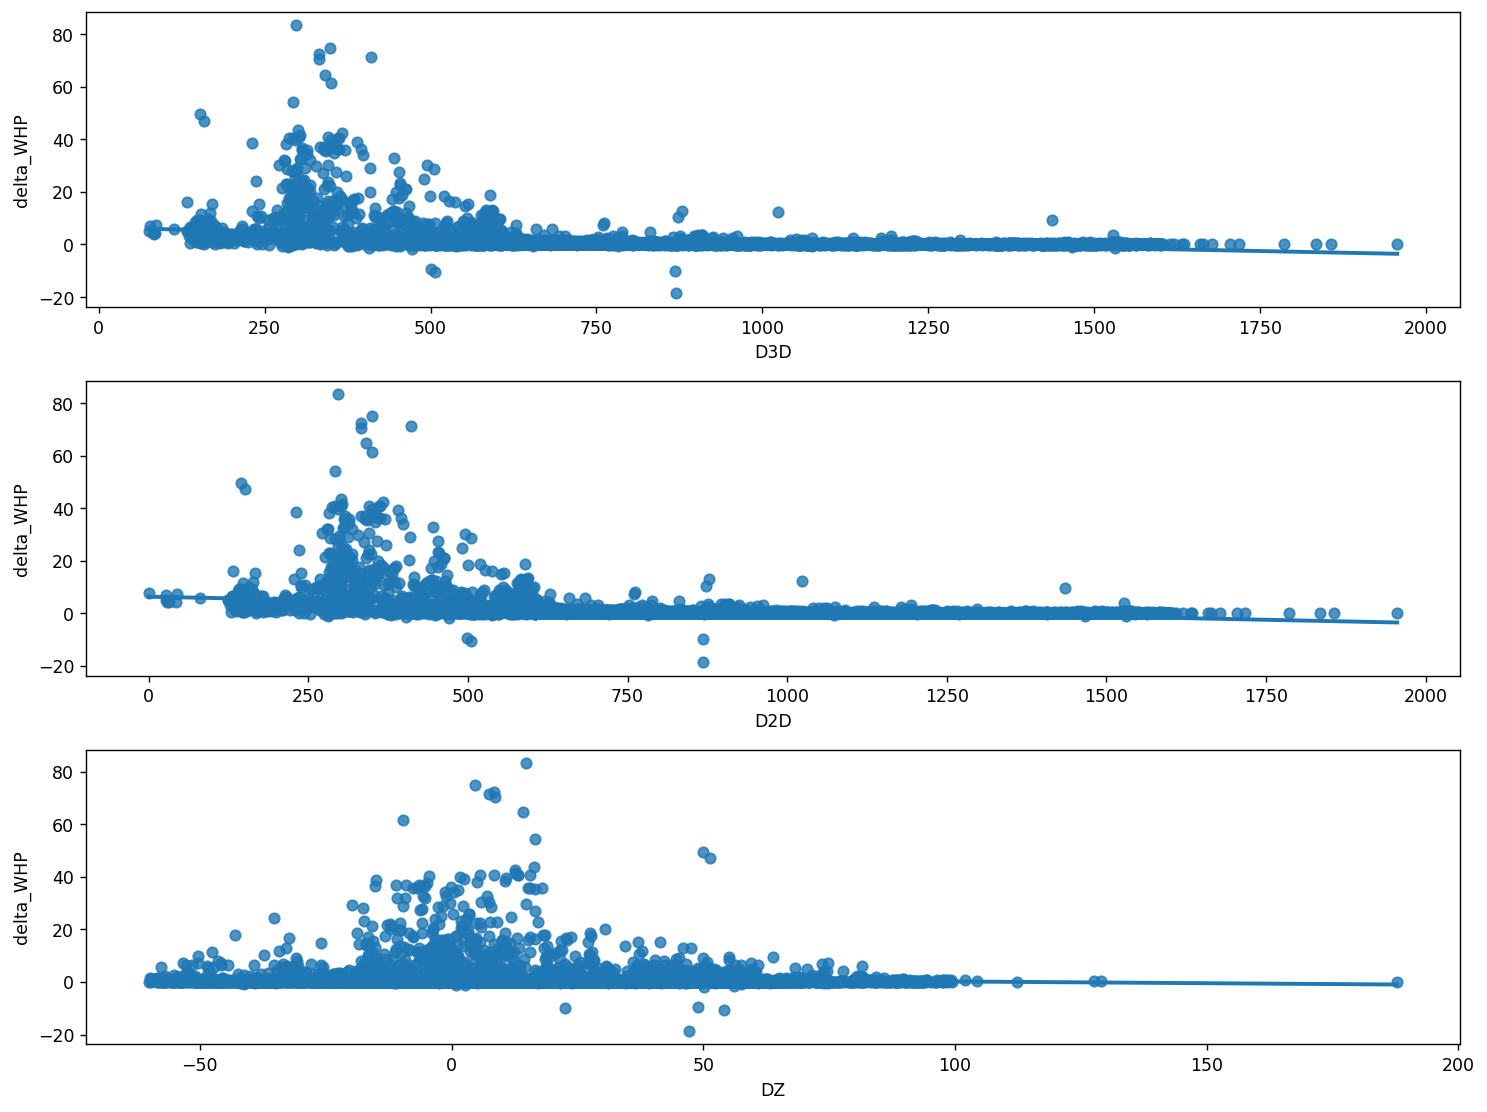

In [22]:
fig, axs = plt.subplots(nrows=3, **{"figsize": (12, 9), "dpi": 125, "facecolor": "white"})

sns.regplot(x='D3D', y='delta_WHP', data=predictions_set[predictions_set.D3D < 9000], ax=axs[0])
sns.regplot(x='D2D', y='delta_WHP', data=predictions_set, ax=axs[1])
sns.regplot(x='DZ',y='delta_WHP', data=predictions_set, ax=axs[2])

plt.tight_layout()

<AxesSubplot:xlabel='#_BARRERAS', ylabel='delta_WHP'>

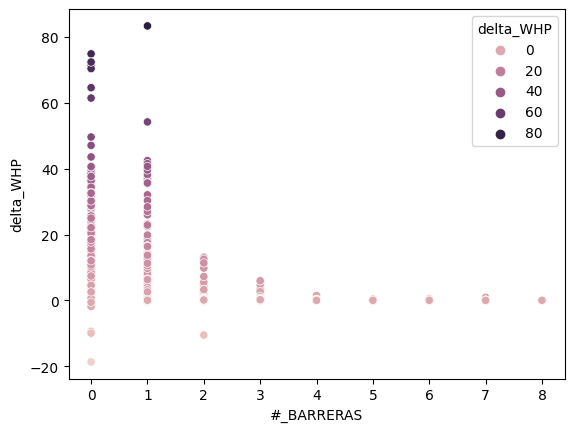

In [23]:
sns.scatterplot(
    data=predictions_set,
    x="#_BARRERAS",
    y="delta_WHP", hue="delta_WHP"
)

<AxesSubplot:xlabel='AZ_cos', ylabel='AZ_sin'>

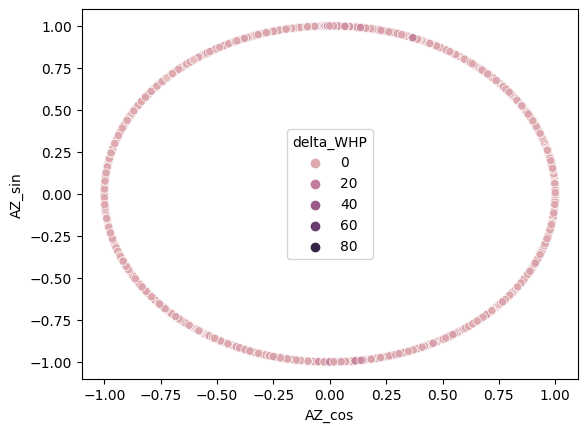

In [25]:
sns.scatterplot(
    data=predictions_set,
    x="AZ_cos",
    y="AZ_sin", hue="delta_WHP"
)

### Submit answer

In [26]:
predictions_set = pd.concat([predictions_set_back, predictions_set["delta_WHP"]], axis=1)

In [27]:
predictions_set.to_csv(
    EXPERIMENT_DIR / "predicciones.csv",
    columns=["ID_FILA", "delta_WHP"],
    header=False,
    index=False,
)